## 利用XGBboost 建立价格预测

### 1.清理数据 
### 2.可视化看数据分布
### 3.大小写处理+标签编码


In [3]:
import xgboost as xgb
print(xgb.__version__) 

2.1.4


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import warnings

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [6]:
# loading the data 
sales = pd.read_csv('Train.csv')
sales.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
sales.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
sales['Item_Weight'].fillna(sales['Item_Weight'].mean(), inplace=True)
sales['Item_Weight'].isnull().sum()

/var/folders/tr/bmkhz4052bq2kh7mn0j74pmw0000gn/T/ipykernel_139/2996708028.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales['Item_Weight'].fillna(sales['Item_Weight'].mean(), inplace=True)


0

In [10]:
sales['Outlet_Size'].describe()       
sales['Outlet_Size'].mode()

0    Medium
Name: Outlet_Size, dtype: object

In [11]:
mode_of_Outlet_size = sales.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [12]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


众数表示大多数情况下哈 然后用自定义函数+布尔值筛选替成这些
- Grocery: Small
- Supermarket Type1 :small
- Supermarket Type2 :Medium
- Supermarket Type3 :Medium

In [14]:
miss_values = sales['Outlet_Size'].isnull()
miss_values

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [15]:
sales.loc[miss_values, 'Outlet_Size'] = sales.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [16]:
sales.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [17]:
sales.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [18]:
sns.set()

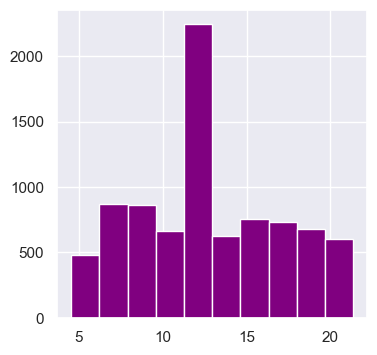

In [19]:
plt.figure(figsize=(4,4))
plt.hist(sales['Item_Weight'], color='purple')
plt.show()

- 平均商品重量在12.5KG

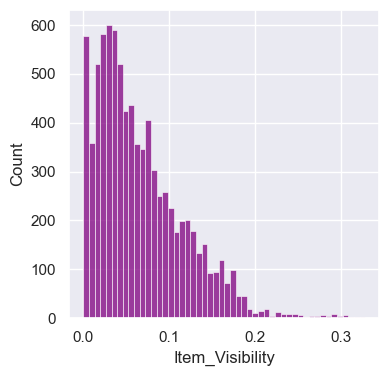

In [21]:
plt.figure(figsize=(4,4))
sns.histplot(sales['Item_Visibility'], color='purple')
plt.show()

- 负/左偏态分布，右侧有尾巴

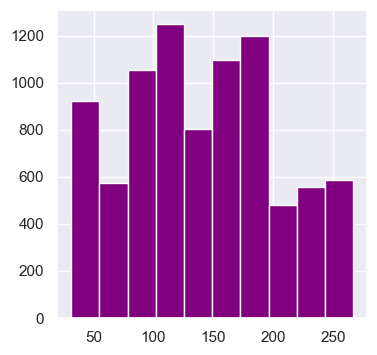

In [23]:
plt.figure(figsize=(4,4))
plt.hist(sales['Item_MRP'], color='purple')
plt.show()

- 我们有很多商品集中在50，100-180左右之间的

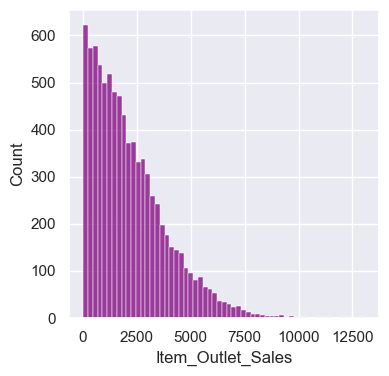

In [25]:
plt.figure(figsize=(4,4))
sns.histplot(sales['Item_Outlet_Sales'], color='purple')
plt.show()

- 负/左偏态分布，右侧有尾巴

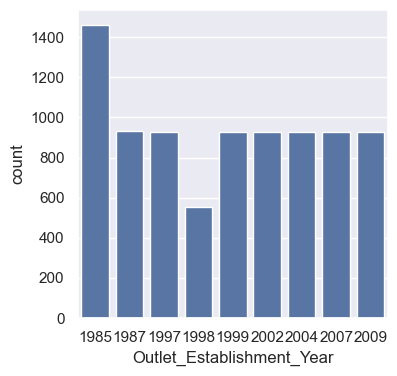

In [27]:
plt.figure(figsize=(4,4))
sns.countplot(x='Outlet_Establishment_Year', data=sales)
plt.show()

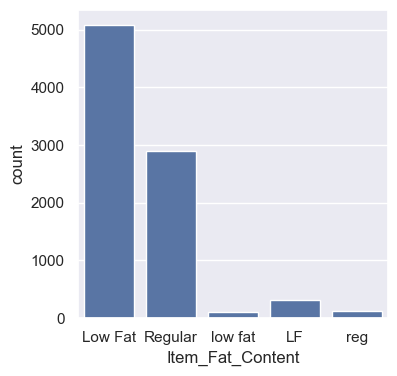

In [28]:
plt.figure(figsize=(4,4))
sns.countplot(x='Item_Fat_Content', data=sales)
plt.show()

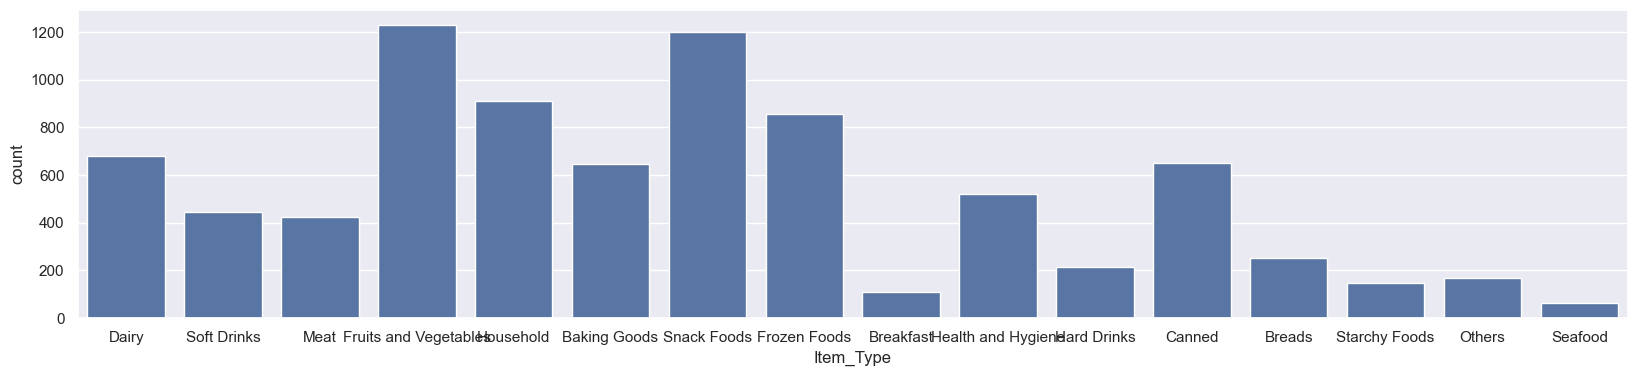

In [29]:
plt.figure(figsize=(20,4))
sns.countplot(x='Item_Type', data=sales)
plt.xticks(range(len(sales['Item_Type'].unique())))
plt.show()

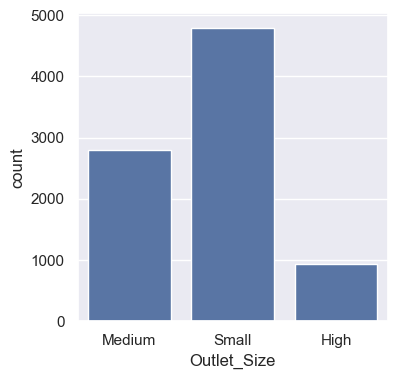

In [30]:
plt.figure(figsize=(4,4))
sns.countplot(x='Outlet_Size', data=sales)
plt.show()

- 中小型产品较多

In [32]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [33]:
sales['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [34]:
sales.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [35]:
sales['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

- 缩写 小写都变正常

In [37]:
encoder = LabelEncoder()  #适用于 有序的类别变量

In [38]:
sales['Item_Identifier'] = encoder.fit_transform(sales['Item_Identifier'])

sales['Item_Fat_Content'] = encoder.fit_transform(sales['Item_Fat_Content'])

sales['Item_Type'] = encoder.fit_transform(sales['Item_Type'])

sales['Outlet_Identifier'] = encoder.fit_transform(sales['Outlet_Identifier'])

sales['Outlet_Size'] = encoder.fit_transform(sales['Outlet_Size'])

sales['Outlet_Location_Type'] = encoder.fit_transform(sales['Outlet_Location_Type'])

sales['Outlet_Type'] = encoder.fit_transform(sales['Outlet_Type'])

In [39]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


In [40]:
X = sales.drop(columns='Item_Outlet_Sales', axis=1)
y = sales.iloc[:,-1]

In [41]:
# pip install category-encoders==<合适的版本号>

## XGboost

#### 训练

In [44]:
from sklearn.metrics import mean_squared_error,r2_score

R2在测试集远低于训练集，说明模型泛化能力较弱，可能存在过拟合！！调参数去！

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [47]:
from xgboost import XGBRegressor
regressor = XGBRegressor( 
                            max_depth=3,           
                            learning_rate=0.01,    
                            n_estimators=600,      
                            subsample=0.7,         
                            colsample_bytree=0.7,         # 让每棵树只用 80% 的特征
                            min_child_weight=5,
                            reg_alpha=0.6,         
                            reg_lambda=0.5 )
regressor.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### 预测

In [49]:
X_train_pred = regressor.predict(X_train)

In [50]:
r2_sales = r2_score(y_train,X_train_pred)    # 计算 y_train（真实值）和 sales_pred（预测值）之间的 R² 评分，衡量模型的拟合度       
print('R Squared value in train = ', r2_sales)

R Squared value in train =  0.6200300963787257


In [51]:
X_test_pred = regressor.predict(X_test)        # 模型在测试集上的预测结果  检查模型对未见数据（测试集）的泛化能力

In [52]:
r2_data = r2_score(y_test, X_test_pred)    

In [53]:
print('R Squared value in test  = ', r2_data)        # 衡量模型在测试集上的表现

R Squared value in test  =  0.5875397108536874


In [54]:
mse_train = mean_squared_error(y_train, X_train_pred)
mse_test = mean_squared_error(y_test, X_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f'Training MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}')
print(f'Testing MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}')
print("y 标准差:", np.std(y))

Training MSE: 1089384.5683, RMSE: 1043.7359
Testing MSE: 1273295.7277, RMSE: 1128.4041
y 标准差: 1706.3995013565946


产品种类、产品重量、产品脂肪含量、可视化程度、类型、	MRP 、产品ID、成立年份、外观大小、位置类型、 商场类型

In [56]:
input_data = (156, 9.300, 0, 0.016047, 4, 249.8092, 9, 1999,1, 0, 1)

print("销售表中第一个产品的预测销售额结果: ", X_train_pred [0])

销售表中第一个产品的预测销售额结果:  2388.9194


## 多项式回归，测试连续的销售额

#### 训练

In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge


poly_reg = PolynomialFeatures(degree = 3)

X_train_poly = poly_reg.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_train_poly , y_train) # 普通线性容易过拟合，试一下ridge

# ridge_regressor = Ridge(alpha=0.5) 
# ridge_regressor.fit(X_train_poly, y_train)

LinearRegression()

In [60]:
y_pred = regressor.predict(poly_reg.transform(X_test))

#### 测试

In [62]:
y_pred = np.array(y_pred)
y_test = np.array(y_test)
y_pred = y_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_pred_1d = y_pred.ravel()
y_test_1d = y_test.ravel()
result = pd.DataFrame({'Actual': y_test_1d, 'predict': y_pred_1d})
result.head(5)

,Actual,predict
0,1544.6560,2354.197787
1,6404.9960,4024.603672
2,1070.6064,1225.841825
3,369.5190,291.022141
4,101.2016,203.918610


In [63]:
r2_score = r2_score(y_test, y_pred)
print('R Squared value in test  = ', r2_score)  

R Squared value in test  =  0.5813760931789711


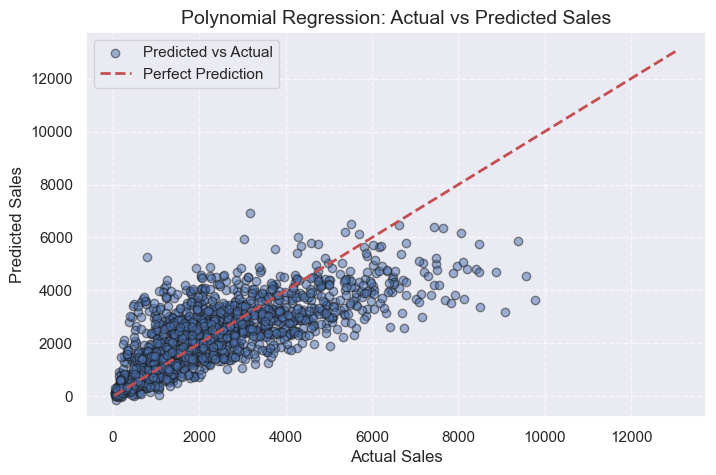

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Sales', fontsize=12)
plt.ylabel('Predicted Sales', fontsize=12)
plt.title('Polynomial Regression: Actual vs Predicted Sales', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()